# Comparison of All Models - Backtesting, Vizualization

This notebook compares all internal models, as well as the standard formula approach. The comparison will be done with the implemented backtesting in mind. 

Additional plots, and vizualizations might be presented.

# Lage innholdsfortegnelse

In [5]:
from internal_models.historical_simulation.historical_simulation import HistoricalSimulation
from internal_models.montecarlo.mc_copula import MonteCarloCopula
from internal_models.montecarlo.mc_vanillagbm import MonteCarloVanillaGBM
from backtesting.christoffersens_test import christoffersen_independence_test
from backtesting.kupiec_test import kupiec_pof_test
from internal_models.GANs.tuned_GANS import solveig_GAN, astrid_GAN, willow_GAN
from utilities.bof_var_plot import plot_bof_var

import pandas as pd
import numpy as np
from dotenv.main import load_dotenv
load_dotenv(override=True)
import os

### Fixing the data. Splitting the data in a testing period.

Split date is set inside environment file.

In [6]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)
    
    pre_test_df = df[df.index < start_test_date]
    test_df = df[df.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

### Deciding on weights for portfolio

**ATTENTION:** Assuming an equally weighted portfolio for now

In [7]:
num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

### Other Paramters

In [8]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))

## Calculating SCR with all internal models

In [ ]:
hs = HistoricalSimulation(returns_df, weights)
mc_copula = MonteCarloCopula(returns_df, weights)
mc_vanilla_GBM = MonteCarloVanillaGBM(returns_df, weights)


[2.61557896e-04 2.84383746e-04 3.18135352e-04 1.79869185e-04
 1.68934802e-04 2.81798850e-04 3.19302203e-05]
[1.26362689e-02 1.24427928e-02 9.67992929e-03 2.06736955e-03
 2.45090122e-03 2.91145713e-03 6.90302518e-05]


In [ ]:
dist_hs, scr_hs = hs.calculate_distribution_and_scr()
dist_mc_copula, scr_mc_copula = mc_copula.calculate_distribution_and_scr()

c:\Users\nicka\master-thesis\packages\Lib\site-packages\scipy\optimize\_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


              REEL           PE    MSCIWORLD           IG          GOV  \
count  3439.000000  3439.000000  3439.000000  3439.000000  3439.000000   
mean      0.500000     0.500000     0.500000     0.500000     0.500000   
std       0.288633     0.288633     0.288633     0.288633     0.288633   
min       0.000291     0.000291     0.000291     0.000291     0.000291   
25%       0.250145     0.250145     0.250145     0.250145     0.250145   
50%       0.500000     0.500000     0.500000     0.500000     0.500000   
75%       0.749855     0.749855     0.749855     0.749855     0.749855   
max       0.999709     0.999709     0.999709     0.999709     0.999709   

                HY        EONIA  
count  3439.000000  3439.000000  
mean      0.500000     0.500000  
std       0.288633     0.288632  
min       0.000291     0.000291  
25%       0.250145     0.249564  
50%       0.500000     0.500000  
75%       0.749855     0.749855  
max       0.999709     0.999709  


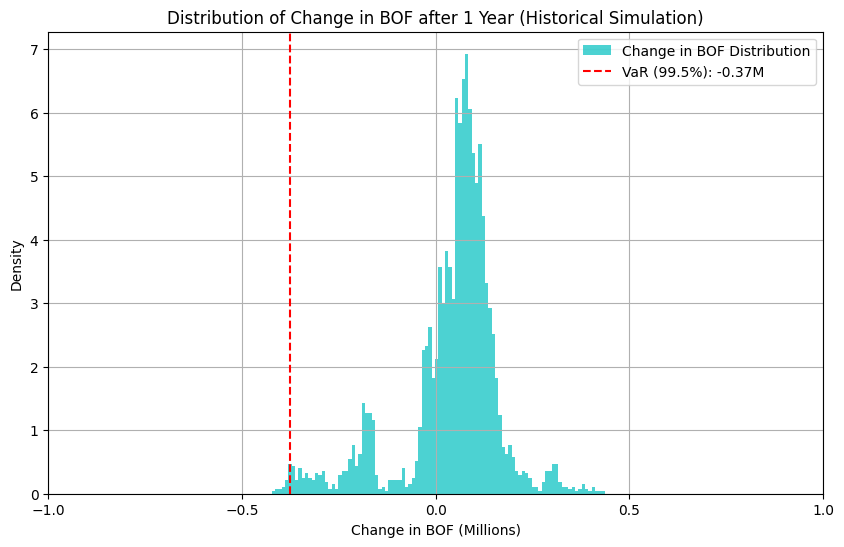

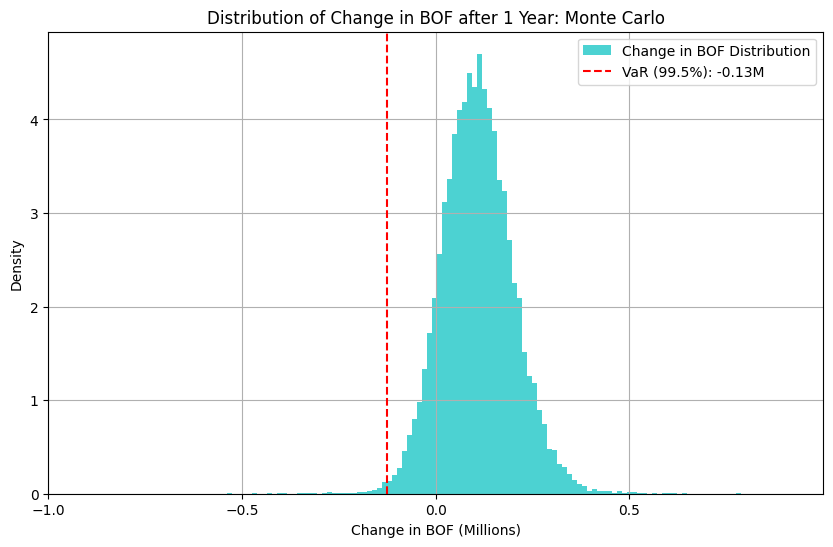

(None, None)

In [6]:
hs.plot_bof_var(dist_hs, scr_hs), mc_copula.plot_bof_var(dist_mc_copula, scr_mc_copula)

## Performing Backtesting

In [7]:
def get_failures_testing(scr):
    bof_0 = assets_0 - liabilities_0

    failures = []

    for t in range(len(test_returns_df)):
        portfolio_return = (test_returns_df.iloc[t].values * weights).sum()
        assets_t1 = assets_0 * (1 + portfolio_return)

        eonia_return = test_returns_df.iloc[t, 6]  
        liabilities_t1 = liabilities_0 * (1 + eonia_return)

        bof_t1 = assets_t1 - liabilities_t1

        delta_bof = bof_t1 - bof_0

        failure = 1 if delta_bof < scr else 0
        failures.append(failure)

    return np.array(failures)

In [8]:
failures_hs = get_failures_testing(scr_hs)
failures_mc_copula = get_failures_testing(scr_mc_copula)

test_stat_ctest_hs, p_value_ctest_hs = christoffersen_independence_test(failures_hs)
test_stat_ctest_mc_copula, p_value_ctest_mc_copula = christoffersen_independence_test(failures_mc_copula)

test_stat_ktest_hs, p_value_ktest_hs = kupiec_pof_test(failures_hs)
test_stat_ktest_mc_copula, p_value_ktest_mc_copula = kupiec_pof_test(failures_mc_copula)

In [9]:
alpha = 0.05

test_results = {
    'Model': ['Historical Simulation', 'Monte Carlo Copula', 'Historical Simulation', 'Monte Carlo Copula'],
    'Test': ['Christoffersen', 'Christoffersen', 'Kupiec', 'Kupiec'],
    'Test Statistic': [test_stat_ctest_hs, test_stat_ctest_mc_copula, test_stat_ktest_hs, test_stat_ktest_mc_copula],
    'P-Value': [p_value_ctest_hs, p_value_ctest_mc_copula, p_value_ktest_hs, p_value_ktest_mc_copula]
}

results_df = pd.DataFrame(test_results)

# Add a column for Test Result based on p-value
results_df['Test Result'] = results_df['P-Value'].apply(lambda p: 'Pass' if p > alpha else 'Fail')

results_df

,Model,Test,Test Statistic,P-Value,Test Result
0,Historical Simulation,Christoffersen,-0.000000,1.000000,Pass
1,Monte Carlo Copula,Christoffersen,-0.000000,1.000000,Pass
2,Historical Simulation,Kupiec,2.526321,0.111961,Pass
3,Monte Carlo Copula,Kupiec,2.526321,0.111961,Pass


In [10]:
failures_hs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
failures_mc_copula

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])